<a href="https://colab.research.google.com/github/IsmailHaris/MS-HPC-AI-GPU/blob/master/Projet_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Black Scholes Numpy basic


In [1]:
import numpy as np
from scipy.stats import norm
import time
import matplotlib.pyplot as plt

 
Risk_Free_Rate = 0.0118 # the current US 10 Year Treasury Rate :1.18% for Mar 18 2020
VOLATILITY = 1 # CBOE Volatility Index in the US markets due to covid19 attein 100% monthly variation in February/March 2020

#We assume the stock don't pay dividends. 

# We first need to define the cumulative distribution fonction of the standard normal distribution.

def cdf(d):
  return norm.cdf(d, loc=0, scale=1)

#Then we define our black scholes analytical formula for a call option and a put option

def black_scholes(Call_Option_Result, Put_Option_Result, stockPrice, optionStrike, Maturity,
                  Riskfree, Volatility):
    S = stockPrice
    K = optionStrike
    T = Maturity
    R = Riskfree
    V = Volatility
    sqrtT = np.sqrt(T)
    d1 = (np.log(S / K) + (R + 0.5 * V * V) * T) / (V * sqrtT)
    d2 = d1 - V * sqrtT
    cdfd1 = cdf(d1)
    cdfd2 = cdf(d2)
 
    expRT = np.exp(- R * T)
    Call_Option_Result[:] = (S * cdfd1 - K * expRT * cdfd2)
    Put_Option_Result[:]= K * expRT * (1.0 - cdfd2) - S * (1.0 - cdfd1)
    
 
def randfloat(rand_var, low, high):
    return (1.0 - rand_var) * low + rand_var * high
 
def main ():

    Number_of_input_elements = [10000,100000,1000000,2000000,3000000,4000000,5000000,10000000,20000000,50000000,75000000,100000000]
    Execution_time_numpy = []

    for i in Number_of_input_elements:
      Call_Option_Result = np.zeros(i)
      Put_Option_Result = np.zeros(i)
      stockPrice = randfloat(np.random.random(i), 5.0, 30.0)
      optionStrike = randfloat(np.random.random(i), 1.0, 100.0)
      Maturity = randfloat(np.random.random(i), 0.25, 10.0) # Duration of the option varies from 3 months to 10 years
 
      start = time.time()
      black_scholes(Call_Option_Result, Put_Option_Result, stockPrice, optionStrike,
                      Maturity, Risk_Free_Rate, VOLATILITY)
      end = time.time()
      print("Numpy Time: %f µsec per option for %f elements" %((1000000*(end-start)/i),i))
      print("Numpy Time: %f µsec for %f elements" %((1000000*(end-start)),i))
      Execution_time_numpy.append((1000000*(end-start)))
    print(Execution_time_numpy)
    plt.plot(Number_of_input_elements,Execution_time_numpy)
    plt.show()

 
#if __name__ == "__main__":
 
main()

Numpy Time: 0.641155 µsec per option for 10000.000000 elements
Numpy Time: 6411.552429 µsec for 10000.000000 elements
Numpy Time: 0.231831 µsec per option for 100000.000000 elements
Numpy Time: 23183.107376 µsec for 100000.000000 elements
Numpy Time: 0.209512 µsec per option for 1000000.000000 elements
Numpy Time: 209511.995316 µsec for 1000000.000000 elements
Numpy Time: 0.211586 µsec per option for 2000000.000000 elements
Numpy Time: 423171.281815 µsec for 2000000.000000 elements
Numpy Time: 0.220991 µsec per option for 3000000.000000 elements
Numpy Time: 662972.927094 µsec for 3000000.000000 elements
Numpy Time: 0.220495 µsec per option for 4000000.000000 elements
Numpy Time: 881981.134415 µsec for 4000000.000000 elements
Numpy Time: 0.225080 µsec per option for 5000000.000000 elements
Numpy Time: 1125399.589539 µsec for 5000000.000000 elements
Numpy Time: 0.226835 µsec per option for 10000000.000000 elements
Numpy Time: 2268347.978592 µsec for 10000000.000000 elements
Numpy Time: 0

KeyboardInterrupt: ignored

Black Scholes with Numba

Numba with Cuda Kernel 


Cuda Time: 34.884429 µsec per option for 10000.000000 elements
Cuda Time: 348844.289780 µsec for 10000.000000 elements
Cuda Time: 0.191376 µsec per option for 100000.000000 elements
Cuda Time: 19137.620926 µsec for 100000.000000 elements
Cuda Time: 0.165427 µsec per option for 1000000.000000 elements
Cuda Time: 165426.731110 µsec for 1000000.000000 elements
Cuda Time: 0.149950 µsec per option for 2000000.000000 elements
Cuda Time: 299899.816513 µsec for 2000000.000000 elements
Cuda Time: 0.139987 µsec per option for 3000000.000000 elements
Cuda Time: 419960.021973 µsec for 3000000.000000 elements
Cuda Time: 0.145470 µsec per option for 4000000.000000 elements
Cuda Time: 581879.138947 µsec for 4000000.000000 elements
Cuda Time: 0.138511 µsec per option for 5000000.000000 elements
Cuda Time: 692557.334900 µsec for 5000000.000000 elements
Cuda Time: 0.140268 µsec per option for 10000000.000000 elements
Cuda Time: 1402676.343918 µsec for 10000000.000000 elements
Cuda Time: 0.133821 µsec pe

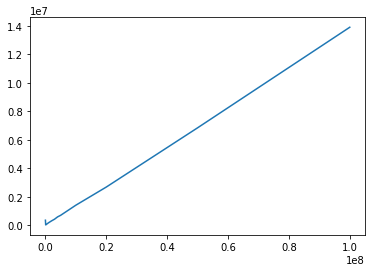

In [56]:

import math
import time
import numpy as np
from numba import cuda
from numba import jit
from scipy.stats import norm
import matplotlib.pyplot as plt
import random

Risk_Free_Rate = 0.0118 # the current US 10 Year Treasury Rate :1.18% for Mar 18 2020
VOLATILITY = 1 # CBOE Volatility Index in the US markets due to covid19 attein 100% monthly variation in February/March 2020


@cuda.jit(device=True)

def cdf_cuda(d): #I can't use a scipy function here
    A1 = 0.31938153
    A2 = -0.356563782
    A3 = 1.781477937
    A4 = -1.821255978
    A5 = 1.330274429
    RSQRT2PI = 0.39894228040143267793994605993438
    K = 1.0 / (1.0 + 0.2316419 * math.fabs(d))
    ret_val = (RSQRT2PI * math.exp(-0.5 * d * d) *
               (K * (A1 + K * (A2 + K * (A3 + K * (A4 + K * A5))))))
    if d > 0:
        ret_val = 1.0 - ret_val
    return ret_val

#let's define our Cuda Kernel 

@cuda.jit
def black_scholes_cuda_kernel(Call_Option_Result, Put_Option_Result, S, K, T, R, V):
    #    S = stockPrice
    #    K = optionStrike
    #    T = maturity
    #    R = Riskfree
    #    V = Volatility



    i = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    #cuda.threadIdx.x this is the unique thread ID within a 1D block 
    #cuda.blockIdx.x   this is the unique block ID within the 1D grid
    stride = cuda.blockDim.x * cuda.gridDim.x  



    #Thread indices beyond the length of the input (S.shape[0], since S is a NumPy array) automatically skip over the for loop.
    if i >= S.shape[0]:
        return


    sqrtT = math.sqrt(T[i])
    d1 = (math.log(S[i] / K[i]) + (R + 0.5 * V * V) * T[i]) / (V * sqrtT)
    d2 = d1 - V * sqrtT

    cdfd1 = cdf_cuda(d1)
    cdfd2 = cdf_cuda(d2)

    expRT = math.exp((-1. * R) * T[i])
    Call_Option_Result[i] = (S[i] * cdfd1 - K[i] * expRT * cdfd2)
    Put_Option_Result[i] = (K[i] * expRT * (1.0 - cdfd2) - S[i] * (1.0 - cdfd1))
    

#let's define now our Cuda function that will use the Cuda Kernel set above. This is where I will define my block size and grid size. 
def black_scholes_cuda(stockPrice, optionStrike, Maturity, Riskfree, Volatility):

    blockdim = 1024,1  # number of threads per block
    griddim = int(math.ceil(float(len(stockPrice))/blockdim[0])),1  # number of blocks in the grid
    stream = cuda.stream()


    OPT_N = len(stockPrice) #My reference in terme of size because 1 stockPrice gives me One Option price (call or put)

    #Send data and empty data to the GPU (device)
    GPU_callResult = cuda.to_device(np.zeros(OPT_N), stream)
    GPU_putResult = cuda.to_device(np.zeros(OPT_N), stream)
    GPU_stockPrice = cuda.to_device(stockPrice, stream)
    GPU_optionStrike = cuda.to_device(optionStrike, stream)
    GPU_maturity = cuda.to_device(Maturity, stream)

    #Run the kernel 
    black_scholes_cuda_kernel[griddim, blockdim, stream](
            GPU_callResult, GPU_putResult, GPU_stockPrice, GPU_optionStrike,
            GPU_maturity, Riskfree, Volatility)
    
    #Collect results from GPU to the CPU host
    Call_Option_Result = GPU_callResult.to_host(stream)
    Put_Option_Result= GPU_putResult.to_host(stream)


    stream.synchronize()


def main ():

    Number_of_input_elements = [10000,100000,1000000,2000000,3000000,4000000,5000000,10000000,20000000,50000000,75000000,100000000]
    Execution_time_cuda = []

    for i in Number_of_input_elements:
      stockPrice = [random.uniform(5.0, 30.0) for j in range(i)]
      optionStrike = [random.uniform(1.0, 100.0) for j in range(i)]
      Maturity = [random.uniform(0.25, 10.0) for j in range(i)]
      
      start = time.time()
      black_scholes_cuda(stockPrice, optionStrike,Maturity, Risk_Free_Rate, VOLATILITY)
      end = time.time()
      print("Cuda Time: %f µsec per option for %f elements" %((1000000*(end-start)/i),i))
      print("Cuda Time: %f µsec for %f elements" %((1000000*(end-start)),i))
      Execution_time_cuda.append((1000000*(end-start)))
    plt.plot(Number_of_input_elements,Execution_time_cuda)
    plt.show()

 
#if __name__ == "__main__":
 
main()
